### Data extraction "Joc de l'Habitatge"

In [34]:
import pymysql
import csv
import time
from datetime import datetime, date
import calendar
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import math
import scipy.stats as stats

from collections import Counter

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


In [35]:
title_font = {'fontname': 'Helvetica', 'size': '14', 'color': 'black', 'weight': 'bold', 'verticalalignment': 'bottom'}  # Bottom vertical alignment for more space
axis_font = {'fontname': 'Helvetica', 'size': '12', 'weight': 'bold', 'color': 'black'}
ticks_font = {'fontname': 'Helvetica', 'size': '10',  'color': 'black', 'weight': 'bold'}

# Colors disseny
colors = ["#009fe3", "#20b200"]
tricolors_green = ["#8fd87f", "#20b200", "#105900"]

# Colors blanc/negre
colors = [ 'black', 'white']
bicolors = ['black', '#CCCCCC']
tricolors = ['#CCCCCC', '#888888', 'black']
tricolors_white = ['#FFFFFF', '#888888', 'black']

bicolors_black = ['black', 'black']
bicolors_white = ['white', 'white']
bicolors_grey = ['#CCCCCC', '#CCCCCC']


#### ToDo: Revise the control variables

In [36]:
def data_extraction():

    host = '127.0.0.1'
    db = pymysql.connect(user='bibliolab', passwd='bibliolab2019', host=host, db='bibliolab_granollers')

    with db:
        
        
        # Database game
        c_game = db.cursor()
        c_game.execute("SELECT GAME.id, GAME.status, GAME.experiment, GAME.control_intervention FROM game_partida GAME ")
        data_game = c_game.fetchall()

        games = []

        for g in data_game:
            
            if g[1] != 'NO_VALID': # Game status
            
                c_round = db.cursor()
                c_round.execute("SELECT ROUND.id, ROUND.num_ronda, ROUND.bucket_inici_ronda, ROUND.bucket_final_ronda, ROUND.rented, ROUND.calculada, ROUND.user_id, ROUND.increment FROM game_ronda ROUND WHERE ROUND.partida_id = %d ORDER BY ROUND.num_ronda ASC " %(g[0]))
                data_round = c_round.fetchall()

                rounds = []

                for r in data_round:
                    if r[5] == 1: # if round is calculated
                        round_ = {'id': r[0],
                                 'num_round': r[1],
                                 'price_init': r[2],
                                 'price_fini': r[3],
                                 'is_rented': r[4],
                                 'user_id': r[6],
                                 'increment': r[7],
                                 }
                        rounds.append(round_)
                        
                game = {'id': g[0],
                        'status': g[1],
                        'experiment': g[2],
                        'control_intervention': g[3],
                        'rounds': rounds
                       }
                
                if game['status'] != 'TEST':
                    games.append(game)


        # Database user
        c_user = db.cursor()
        c_user.execute("SELECT USER.id, USER.is_robot, USER.consent, USER.socio_pr1, USER.socio_pr2, USER.socio_pr3, USER.socio_pr4, USER.socio_pr5, USER.socio_pr6, USER.socio_pr7, USER.frame_pr1, USER.frame_pr2, USER.frame_pr3, USER.frame_pr4, USER.frame_pr5, USER.frame_pr6, USER.verification_attempts, USER.status, USER.acabat, USER.bots, USER.endowment_initial, USER.endowment_current, USER.endowment_final, USER.expenses, USER.tickets, USER.house, USER.house_price, USER.partida_id, USER.comment, USER.enquesta_final_pr1, USER.enquesta_final_pr2, USER.enquesta_final_pr3, USER.enquesta_final_pr4, USER.enquesta_final_pr5, USER.enquesta_final_pr6 FROM game_user USER ")
        data_user = c_user.fetchall()


        # Collect user data
        participants = []

        for u in data_user:

            control = {
                'is_robot': u[1], # is a robot?
                'consent': u[2], # is consented?
                'status': u[17], # status
                'acabat': u[18], # acabat?
                'bots': u[19], # number of bots selection
                'verification_attempts': u[16], # verification questions attemps
                'comments': u[28] # empty ("") if its all ok
            }
    
            #ToDo: Revise the control
            if control['is_robot'] == 0 and control['consent'] == 1 and control['acabat'] == 1 and control['bots'] < 2 and control['comments']=='':

                # Round information
                c_user_round = db.cursor()
                c_user_round.execute("SELECT USER_ROUND.id, USER_ROUND.ha_seleccionat, USER_ROUND.seleccio, USER_ROUND.temps_seleccio, USER_ROUND.endowment_variation, USER_ROUND.ronda_id, USER_ROUND.user_id, ROUND.num_ronda, ROUND.bucket_inici_ronda, ROUND.user_id, ROUND.increment FROM game_userronda USER_ROUND INNER JOIN game_ronda ROUND ON ROUND.id = USER_ROUND.ronda_id WHERE USER_ROUND.user_id = %d ORDER BY USER_ROUND.ronda_id ASC " %(u[0]))
                data_user_round = c_user_round.fetchall() 

                rounds = []
                num_round_rented = None
                
                for ur in data_user_round:  
                    round_ = {'id': ur[0],
                              'num_round': ur[7],
                              'is_selected': ur[1], # round is selected?
                              'selection': ur[2], # round selection
                              'time_selection': ur[3], # time selection
                              'price': ur[8],
                              'increment': ur[10] #-1: baixa, 0: es queda igual, +1: puja
                             }

                    rounds.append(round_)
                    
                    if ur[9] == u[0] and ur[2]:
                        num_round_rented = ur[7]
                    

                socio = {'socio_pr1': u[3], # q: Identitat de gènere r1: Home; r2: Dona; r3: No binària; r4: No vull contestar;
                         'socio_pr2': u[4], # q: Rang d'edat r1: Menor de 14; r2: 14 - 17; r3: 18 - 24; r4: 25 - 34; r5: 35 - 44; r6: 45 - 54; r7: 55 - 64; r8: Major de 65;
                         'socio_pr3': u[5], # q: Codi Postal
                         'socio_pr4': u[6], # q: Nivell d'estudis finalitzats r1: Cap; r2: Obligatoris; r3: Secundaris generals; r4: Secundaris professionals; r5: Universitaris; r6: Altres;
                         'socio_pr5': u[7], # q: Amb qui vius? r1: Sol; r2: Llar sense persones a càrrec; r3: Llars amb persones a càrrec; r4: Més persones que no són parella;
                         'socio_pr6': u[8], # q: Règim de tinença de la teva llar r1: En propietat; r2: En propietat pendent de pagament (hipoteca); r3: En lloguer o relloguer a preu de mercat; r4: En lloguer o relloguer a preu inferior al de mercat ; r5: En cessió gratuïta; r6: Habitació de lloguer; r7: Ocupació; r8: Altres; 
                         'socio_pr7': u[9], # q: Ets propietari d’algun habitatge que està en règim de lloguer? r1: Sí; r2: No; r3: No vull contestar;
                        }

                frame = {'frame_pr1': u[10], # q: En quina mesura comparteixes la inquietud triada pels veïns que han participat en el co-disseny d'aquest experiment sobre el tema de l'habitatge? r1: Poc; r2: Normal; r3: Molt;
                         'frame_pr2': u[11], # q: En quina mesura estàs d'acord amb una regulació que limiti el preu del lloguer? r1: Poc; r2: Normal; r3: Molt
                         'frame_pr3': u[12], # q: En quina mesura estàs d'acord amb una regulació fiscal que permeti la concessió d'ajuts per facilitar l'accés a l'habitatge i mantenir el preu? r1: Poc; r2: Normal; r3: Molt;
                         'frame_pr4': u[13], # q: Quin creus que és el preu mig del lloguer d’una casa de 70m2 en bones condicions a {municipi}? r1: 300 euros; r2: 400 euros; r3: 500 euros; r4: 600 euros; r5: 700 euros; r6: 800 euros; r7: 900 euros; r8: 1000 euros;
                         'frame_pr5': u[14], # q: Quin percentatge dels teus ingressos mensuals nets dediques a despeses associades a l’accés a l’habitatge? r1: <25%; r2: 25-34%; r3: 35-44%; r4: 45-54%; r5: 55-64%; r6: 65-74%; r7: >74%;
                         'frame_pr6': u[15], # q: Quin percentatge dels teus ingressos mensuals nets consideres just dedicar a despeses associades a l’accés a l’habitatge? r1: <25%; r2: 25-34%; r3: 35-44%; r4: 45-54%; r5: 55-64%; r6: 65-74%; r7: >74%;
                        }
                
                final = {'final_pr1': u[29], # q: En quina mesura creus que ha d’haver-hi un control públic de l’habitatge? 
                         'final_pr2': u[30], # q: En quina mesura estàs d’acord amb la necessitat de tenir un sistema que garanteixi la consideració de l’habitatge com un bé de primera necessitat?
                         'final_pr3': u[31], # q: En quina mesura creus que la presència de pisos buits afecta la situació de l'habitatge al municipi? 
                         'final_pr4': u[32], # q: En quina mesura estàs d’acord amb la necessitat de prioritzar el dret a l’habitatge per a col·lectius vulnerables? 
                         'final_pr5': u[33], # q: Coneixes iniciatives d’habitatge cooperatiu?
                         'final_pr6': u[34], # q: En quina mesura creus que les iniciatives d’habitatge cooperatiu poden millorar l’eficiència del model d’habitatge actual? (opcional)
                }
                

                # Participant Dictionary
                game = [g for g in games if g['id'] == u[27]][0]
                
                participant = {'id': u[0],
                               'game': game,
                               'intervention': game['control_intervention'],
                               'control': control,
                               'socio': socio,
                               'frame': frame,
                               'final': final,
                               'rounds': rounds,
                               'endowment_initial': u[20], 
                               'endowment_current': u[21],
                               'endowment_final': u[22],
                               'expenses': u[23],
                               'tickets': u[24], 
                               'house': u[25], 
                               'house_price': u[26], 
                               'round_rented': num_round_rented
                              }
                
                participants.append(participant)
        
        
    return games, participants
    

In [37]:
games, participants = data_extraction()

df_games = pd.DataFrame(games)
df_participants = pd.DataFrame(participants)

rent_GR = 1933
high_limit_GR = 645
low_limit_GR = 477

participants_TS = [p for p in participants if p['game']['experiment'] == 'Test']
participants_FP = [p for p in participants if p['game']['experiment'] == 'FortPienc']
participants_GR = [p for p in participants if p['game']['experiment'] == 'Granollers']
participants_OM = [p for p in participants if p['game']['experiment'] == 'Olesa']

df_participants_TS = pd.DataFrame([p for p in participants if p['game']['experiment'] == 'Test'])
df_participants_FP = pd.DataFrame([p for p in participants if p['game']['experiment'] == 'FortPienc'])
df_participants_GR = pd.DataFrame([p for p in participants if p['game']['experiment'] == 'Granollers'])
df_participants_OM = pd.DataFrame([p for p in participants if p['game']['experiment'] == 'Olesa'])

df_games_TS = df_games.loc[df_games['experiment'] == 'Test']
df_games_FP = df_games.loc[df_games['experiment'] == 'FortPienc']
df_games_GR = df_games.loc[df_games['experiment'] == 'Granollers']
df_games_OM = df_games.loc[df_games['experiment'] == 'Olesa']

print '----------------------'
print 'Games and Participants'
print 'TS: ' + str(len(df_games_TS)) + '(' + str(6*len(df_games_TS)) + ' p.)' 
print 'FP: ' + str(len(df_games_FP)) + '(' + str(6*len(df_games_FP)) + ' p.)' 
print 'GR: ' + str(len(df_games_GR)) + '(' + str(6*len(df_games_GR)) + ' p.)' 
print 'OM: ' + str(len(df_games_OM)) + '(' + str(6*len(df_games_OM)) + ' p.)' 

print '------------------'
print 'Valid Participants'
print 'TS: ' + str(len(df_participants_TS))
print 'FP: ' + str(len(df_participants_FP))
print 'GR: ' + str(len(df_participants_GR))
print 'OM: ' + str(len(df_participants_OM))




----------------------
Games and Participants
TS: 0(0 p.)
FP: 0(0 p.)
GR: 26(156 p.)
OM: 0(0 p.)
------------------
Valid Participants
TS: 0
FP: 0
GR: 134
OM: 0


### Sociodemographics

In [38]:
text_dataset = 'socio_GR' 
participants = participants_GR
df_participants_socio = pd.DataFrame(list(df_participants_GR['socio']))


#### Identitat de genere

|  |socio_pr1|
|----------|
|r1| Home | 
|r2| Dona | 
|r3| No binària | 
|r4| No vull contestar |

#### Rang d'edat

|  |socio_pr2| 
|------------|
|r1| Menor de 14 | 
|r2| 14 - 17 | 
|r3| 18 - 24 | 
|r4| 25 - 34 | 
|r5| 35 - 44 | 
|r6| 45 - 54 | 
|r7| 55 - 64 | 
|r8| Major de 65|

-----
Total Participants: 134
Total Women: 89 - 0.66
Total Men:  43 - 0.32
Total Other:  2 - 0.01
-----


,socio_pr2
count,133.000000
mean,42.515038
std,17.026599
min,21.000000
25%,29.500000
50%,39.500000
75%,49.500000
max,82.000000


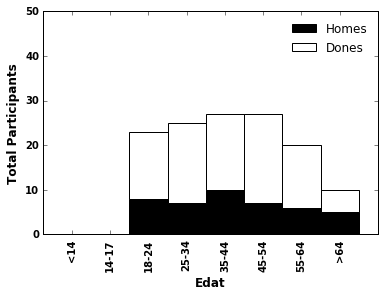

In [39]:
socio_pr2 = [p['socio']['socio_pr2'] for p in participants]

socio_pr2_women = [p['socio']['socio_pr2'] for p in participants if p['socio']['socio_pr1'] == 'W']
socio_pr2_men = [p['socio']['socio_pr2'] for p in participants if p['socio']['socio_pr1'] == 'M']
socio_pr2_none = [p['socio']['socio_pr2'] for p in participants if p['socio']['socio_pr1'] != 'W' and p['socio']['socio_pr1'] != 'M']

print ('-----')
print ('Total Participants: %d' %(len(participants)))
print ('Total Women: %d - %.2f' %(len(socio_pr2_women), float(len(socio_pr2_women))/float(len(participants))))
print ('Total Men:  %d - %.2f' %(len(socio_pr2_men), float(len(socio_pr2_men))/float(len(participants))))
print ('Total Other:  %d - %.2f' %(len(socio_pr2_none), float(len(socio_pr2_none))/float(len(participants))))
print ('-----')


df_ages = pd.DataFrame({'label':['<14', '14-17', '18-24', '25-34', '35-44', '45-54', '55-64', '>64'], 
                         'value':[socio_pr2.count('r1'), socio_pr2.count('r2'), socio_pr2.count('r3'), 
                                  socio_pr2.count('r4'), socio_pr2.count('r5'), socio_pr2.count('r6'), 
                                  socio_pr2.count('r7'), socio_pr2.count('r8')]})

df_ages['per'] = df_ages['value']/len(participants)

df_women = pd.DataFrame({'label':['<14', '14-17', '18-24', '25-34', '35-44', '45-54', '55-64', '>64'], 
                         'value':[socio_pr2_women.count('r1'), socio_pr2_women.count('r2'), socio_pr2_women.count('r3'), 
                                  socio_pr2_women.count('r4'), socio_pr2_women.count('r5'), socio_pr2_women.count('r6'), 
                                  socio_pr2_women.count('r7'), socio_pr2_women.count('r8')]})

df_men = pd.DataFrame({'label':['<14', '14-17', '18-24', '25-34', '35-44', '45-54', '55-64', '>64'],
                       'value':[socio_pr2_men.count('r1'), socio_pr2_men.count('r2'), socio_pr2_men.count('r3'), 
                            socio_pr2_men.count('r4'), socio_pr2_men.count('r5'), socio_pr2_men.count('r6'), 
                            socio_pr2_men.count('r7'), socio_pr2_men.count('r8')]})

max_y = 10

df_gender = pd.DataFrame()
df_gender['men'] = df_men['value']
df_gender['women'] = df_women['value']

plt.clf()
fig, ax = plt.subplots()
ax = df_gender[['men', 'women']].plot.bar(stacked=True, width=1, position=0.5, ax=ax, alpha=1, color=[colors[0], colors[1]])
max_y = 50
plt.xticks(np.arange(0,9),('<14', '14-17', '18-24', '25-34', '35-44', '45-54', '55-64', '>64'), **ticks_font)
plt.yticks(**ticks_font)
plt.xlabel('Edat', **axis_font)
plt.ylabel('Total Participants', **axis_font)
plt.legend(['Homes','Dones'], fancybox=True, framealpha=0)
plt.ylim(0,max_y)

plt.savefig('figures/Granollers/01_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)

mapping = {'r1': float(1+13)/2, 'r2': float(14+17)/2, 'r3': float(18+24)/2, 'r4': float(25+34)/2, 'r5': float(35+44)/2, 'r6': float(45+54)/2, 'r7': float(55+64)/2, 'r8': float(65+99)/2, '': None}
df_participants_socio_numeric = df_participants_socio.replace({'socio_pr2': mapping})
df_participants_socio_numeric.describe()


#### On vius? (CP)

| |socio_pr3|
|-----------|
|**Granollers**|08401 / 08402 / 08403 |
|**Olesa de Montserrat**| 08640 |
|**Fort Pienc**| 08013 |

#### Olesa

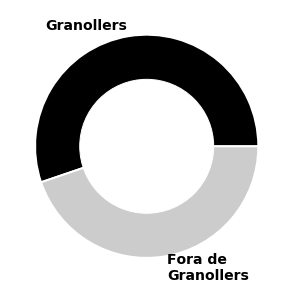

08401    0.276119
08402    0.179104
08420    0.067164
08403    0.052239
08400    0.044776
08440    0.037313
08530    0.037313
08430    0.029851
08520    0.022388
08186    0.022388
08185    0.014925
08187    0.014925
08410    0.014925
08450    0.014925
08100    0.014925
Name: 0, dtype: float64

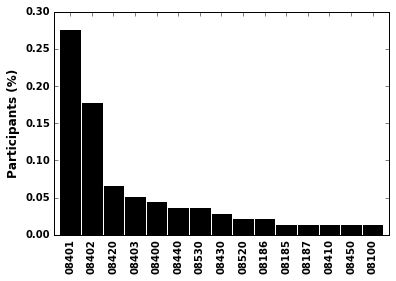

In [40]:
socio_pr3 = [p['socio']['socio_pr3'] for p in participants]


################
## Granollers ##
################

granollers = socio_pr3.count('08400') + socio_pr3.count('8400') + socio_pr3.count('08401') + socio_pr3.count('8401') + socio_pr3.count('08402') + socio_pr3.count('8402') + socio_pr3.count('08403') + socio_pr3.count('8403')
fora_granollers = len(socio_pr3) - granollers

df_granollers = pd.DataFrame({'label':['Granollers', 'Fora de\nGranollers'], 
                              'value':[granollers, fora_granollers]})

df_granollers['perc'] =  df_granollers['value']/len(socio_pr3)


labels = ['Granollers', 'Fora de\nGranollers']

fig = plt.figure(figsize=(5,5))
circle = plt.Circle((0,0),0.6,color='white',alpha=1)

patches, texts = plt.pie([granollers, fora_granollers], labels=labels, colors=bicolors,
                         wedgeprops={'linewidth': 2, 'linestyle': 'solid', 'antialiased': True, 'edgecolor': 'white'})

[ _.set_fontsize(14) for _ in texts ]
[ _.set_fontweight('bold') for _ in texts ]

p=plt.gcf()
p.gca().add_artist(circle)
plt.savefig('figures/Granollers/02_granollers_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

df_socio_pr3 = pd.DataFrame(socio_pr3)
df_socio_pr3
df_socio_pr3[0].value_counts(normalize=True)[0:15].plot(kind='bar', rot=90, width=1, color=colors[0], edgecolor = "white")
plt.xlabel('', **axis_font)
plt.ylabel('Participants (%)', **axis_font)
plt.xticks(**ticks_font)
plt.yticks(**ticks_font)

plt.savefig('figures/Granollers/02_granollers_pc_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)

df_socio_pr3[0].value_counts(normalize=True)[0:15]


#### Nivell d'estudis finalitzats

|  | socio_pr4 |
|------------------------------|
|r1|Cap|
|r2|Obligatoris (primària, EGB, ESO)|
|r3|Secundaris generals (batxillerat, PREU, BUP, COU)|
|r4|Secundaris professionals (comerç, FP1, FP2, mòduls, grau mitja/superior)|
|r5|Universitaris (grau, diplomatura, llicenciatura, màster, postgrau, doctorat)|
|r6|Altres|

r1    0.044776
r2    0.134328
r3    0.186567
r4    0.164179
r5    0.447761
r6    0.014925
      0.007463
Name: socio_pr4, dtype: float64

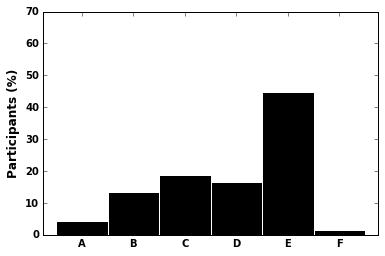

In [41]:

plt.clf()

plt_studies = df_participants_socio['socio_pr4'].value_counts(normalize=True)[['r1', 'r2', 'r3', 'r4', 'r5', 'r6']].plot(kind='bar', rot=0, width=1, color=colors[0], edgecolor = "white")
#plt_studies.set_xticklabels(['Cap', 'Obligatoris', 'Secundaris\nGenerals', 'Secundaris\nProfessionals', 'Universitaris', 'Altres'])
plt_studies.set_xticklabels(['A', 'B', 'C', 'D', 'E', 'F'])

max_y = 0.7
plt.xticks(**ticks_font)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7], ['0',10,20,30,40,50,60,70], **ticks_font)
plt.xlabel('', **axis_font)
plt.ylabel('Participants (%)', **axis_font)
plt.ylim(0,max_y)

plt.savefig('figures/Granollers/04_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)

df_participants_socio['socio_pr4'].value_counts(normalize=True)[['r1', 'r2', 'r3', 'r4', 'r5', 'r6', '']]


#### Amb qui vius?


|| socio_pr5 |
|------------|
|r1|Sol|
|r2|Llar sense persones a càrrec|
|r3|Llar amb persones a càrrec|
|r4|Més persones que no són parella|

r1    0.097015
r2    0.231343
r3    0.514925
r4    0.149254
      0.007463
Name: socio_pr5, dtype: float64

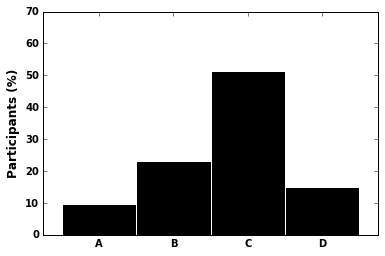

In [42]:
plt_who_lives = df_participants_socio['socio_pr5'].value_counts(normalize=True)[['r1', 'r2', 'r3', 'r4']].plot(kind='bar', rot=0, width=1, color=colors[0], edgecolor = "white")

# plt_studies.get_legend().remove()
#plt_who_lives.set_xticklabels(['Sol', 'Llar sense persones\na carrec', 'Llar amb persones\na carrec', 'Mes persones que\nno son parella'])
plt_who_lives.set_xticklabels(['A', 'B', 'C', 'D'])

max_y = 0.7
plt.xticks(**ticks_font)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7], [0,10,20,30,40,50,60,70], **ticks_font)
plt.xlabel('', **axis_font)
plt.ylabel('Participants (%)', **axis_font)
plt.ylim(0,max_y)

#plt.text(0, max_y - 15, 
#         'A: Sol\nB: Llar sense persones a carrec\nC: Llar amb persones a carrec\nD: Mes persones que no son parella',
#         **ticks_font)
plt.savefig('figures/Granollers/05_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)

df_participants_socio['socio_pr5'].value_counts(normalize=True)[['r1', 'r2', 'r3', 'r4', '']]


#### Règim de tinença de la teva llar
| |socio_pr6|
|----------|
|r1|En propietat|
|r2|En propietat pendent de pagament (hipoteca)|
|r3|En lloguer o relloguer a preu de mercat|
|r4|En lloguer o relloguer a preu inferior al de mercat|
|r5|En cessió gratuïta|
|r6|Habitació de lloguer|
|r7|Ocupació|
|r8|Altres|

r1    0.343284
r2    0.208955
r3    0.238806
r4    0.067164
r5         NaN
r6    0.074627
r7    0.007463
r8    0.052239
      0.007463
Name: socio_pr6, dtype: float64

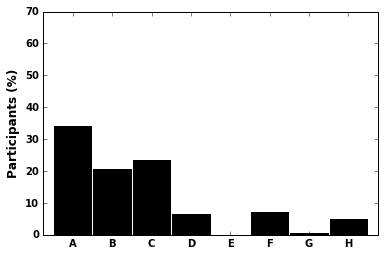

In [43]:
plt.clf()
plt_home_tenancy = df_participants_socio['socio_pr6'].value_counts(normalize=True)[['r1', 'r2', 'r3', 'r4','r5', 'r6', 'r7', 'r8']].plot(kind='bar', rot=0, width=1, color=colors[0], edgecolor = "white")
# plt_home_tenancy.set_xticklabels(['En propietat', 'En propietat pendent de pagament (hipoteca)', 'En lloguer o relloguer a preu de mercat', 'En lloguer o relloguer a preu inferior al de mercat', 'En cessio gratuita', 'Habitacio de lloguer', 'Ocupacio', 'Altres'])
plt_home_tenancy.set_xticklabels(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'])

max_y = 0.7
plt.xticks(**ticks_font)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7], ['0',10,20,30,40,50,60,70], **ticks_font)
plt.xlabel('', **axis_font)
plt.ylabel('Participants (%)', **axis_font)
plt.ylim(0,max_y)

#plt.text(0, max_y - 25, 
#         'A: En propietat\nB: En propietat pendent de pagament (hipoteca)\nC: En lloguer o relloguer a preu de mercat\nD: En lloguer o relloguer a preu inferior al de mercat\nE: En cessio gratuita\nF: Habitacio de lloguer\nG: Ocupacio\nH: Altres',
#         **ticks_font)
plt.savefig('figures/Granollers/06_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)

df_participants_socio['socio_pr6'].value_counts(normalize=True)[['r1', 'r2', 'r3', 'r4','r5', 'r6', 'r7', 'r8','']]


#### Ets propietari d’algun habitatge que està en règim de lloguer?
||socio_pr7|
|----------|
|r1|Sí|
|r2|No|
|r3|No vull contestar|

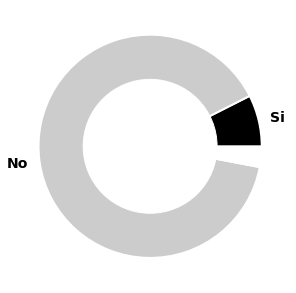

r1    0.074627
r2    0.895522
      0.007463
Name: socio_pr7, dtype: float64

In [44]:
plt.clf()

freq_owner = df_participants_socio['socio_pr7'].value_counts(normalize=True)[['r1', 'r2', '']]

labels = ['Si', 'No', '']

bicolors_none = ['black', '#CCCCCC', '#FFFFFF']

fig = plt.figure(figsize=(5,5))
circle = plt.Circle((0,0),0.6,color='white',alpha=1)

patches, texts = plt.pie(freq_owner, labels=labels, colors=bicolors_none,
                         wedgeprops={'linewidth': 2, 'linestyle': 'solid', 'antialiased': True, 'edgecolor': 'white'})

[ _.set_fontsize(14) for _ in texts ]
[ _.set_fontweight('bold') for _ in texts ]


p=plt.gcf()
p.gca().add_artist(circle)
plt.savefig('figures/Granollers/07_'+text_dataset+'.png', bbox_inches='tight', dpi=300)
plt.show()

freq_owner

### Frame

In [45]:
text_dataset = 'frame_GR' 
df_participants_frame = pd.DataFrame(list(df_participants_GR['frame']))
df_participants_frame.tail()


,frame_pr1,frame_pr2,frame_pr3,frame_pr4,frame_pr5,frame_pr6
129,,,,,,
130,r3,r3,r3,r5,r1,r2
131,r2,r2,r3,r4,r1,r4
132,r2,r3,r3,r4,r2,r2
133,r2,r3,r3,r1,r2,r2


#### Codiseny

**pr1:** En quina mesura comparteixes la inquietud triada pels veïns que han participat en el co-disseny d'aquesta recerca sobre el tema de l'habitatge?



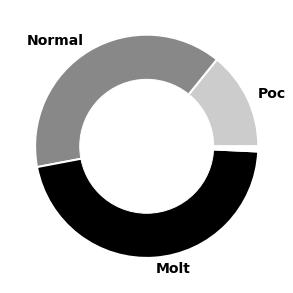

r1    0.141791
r2    0.388060
r3    0.462687
      0.007463
Name: frame_pr1, dtype: float64

In [46]:
pr1_counts = df_participants_frame['frame_pr1'].value_counts(normalize=True)[['r1', 'r2', 'r3','']]
pr1_counts=pr1_counts.fillna(0)

labels = ['Poc', 'Normal', 'Molt', '']

fig = plt.figure(figsize=(5,5))
circle = plt.Circle((0,0),0.6,color='white')

tricolors_none = ['#CCCCCC', '#888888', 'black', '#FFFFFF']

patches, texts = plt.pie(pr1_counts, labels=labels, colors=tricolors_none, 
                                    wedgeprops={'linewidth': 2, 'linestyle': 'solid', 'antialiased': True, 'edgecolor': 'white'})

[ _.set_fontsize(14) for _ in texts ]
[ _.set_fontweight('bold') for _ in texts ]

p=plt.gcf()
p.gca().add_artist(circle)
#plt.title('Regulacio fiscal per ajuts', **title_font)
plt.savefig('figures/Granollers/01_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

pr1_counts

#### Polítiques Públiques

**pr2:** En quina mesura estàs d'acord amb una regulació que limiti el preu del lloguer? **pr3:** En quina mesura estàs d'acord amb una regulació fiscal que permeti la concessió d'ajuts per facilitar l'accés a l'habitatge i mantenir el preu?

||frame_pr2|frame_pr3|
|---------------------|
|r1|Poc|Poc|
|r2|Normal|Normal|
|r3|Molt|Molt|


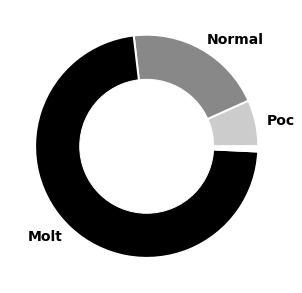

r1    0.067164
r2    0.201493
r3    0.723881
      0.007463
Name: frame_pr2, dtype: float64

In [47]:
pr2_counts = df_participants_frame['frame_pr2'].value_counts(normalize=True)[['r1', 'r2', 'r3','']]

pr2_counts=pr2_counts.fillna(0)

fig = plt.figure(figsize=(5,5))
circle = plt.Circle((0,0),0.6,color='white')

tricolors_none = ['#CCCCCC', '#888888', 'black', '#FFFFFF']

labels = ['Poc', 'Normal', 'Molt', '']

patches, texts = plt.pie(pr2_counts, labels=labels, 
        colors=tricolors_none, 
        wedgeprops={'linewidth': 2, 'linestyle': 'solid', 'antialiased': True, 'edgecolor': 'white'})

[ _.set_fontsize(14) for _ in texts ]
[ _.set_fontweight('bold') for _ in texts ]

p=plt.gcf()
p.gca().add_artist(circle)
#plt.title('Regulacio que limita el preu', **title_font)
plt.savefig('figures/Granollers/02_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)

plt.show()

pr2_counts

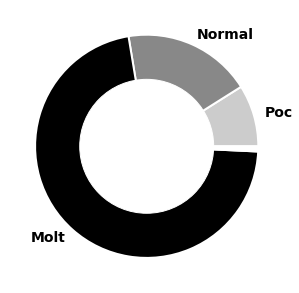

r1    0.089552
r2    0.186567
r3    0.716418
      0.007463
Name: frame_pr3, dtype: float64

In [48]:
pr3_counts = df_participants_frame['frame_pr3'].value_counts(normalize=True)[['r1', 'r2', 'r3','']]
pr3_counts=pr3_counts.fillna(0)

labels = ['Poc', 'Normal', 'Molt', '']

fig = plt.figure(figsize=(5,5))
circle = plt.Circle((0,0),0.6,color='white')

tricolors_none = ['#CCCCCC', '#888888', 'black', '#FFFFFF']

patches, texts = plt.pie(pr3_counts, labels=labels, 
        colors=tricolors_none, 
        wedgeprops={'linewidth': 2, 'linestyle': 'solid', 'antialiased': True, 'edgecolor': 'white'})

[ _.set_fontsize(14) for _ in texts ]
[ _.set_fontweight('bold') for _ in texts ]

p=plt.gcf()
p.gca().add_artist(circle)
#plt.title('Regulacio fiscal per ajuts', **title_font)
plt.savefig('figures/Granollers/03_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

pr3_counts

**pr4:** Quin creus que és el preu mig del lloguer d’una casa de 70m2 en bones condicions a {municipi}?

r1    0.097015
r2    0.119403
r3    0.134328
r4    0.179104
r5    0.223881
r6    0.156716
r7    0.067164
r8    0.014925
Name: frame_pr4, dtype: float64

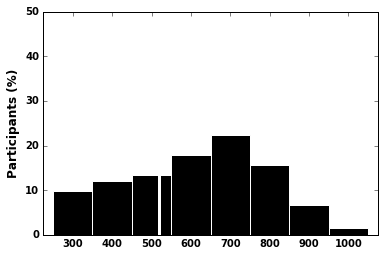

In [49]:
df_participants_frame['frame_pr4']

plt.clf()
plt_rent = df_participants_frame['frame_pr4'].value_counts(normalize=True)[['r1', 'r2', 'r3', 'r4','r5', 'r6', 'r7', 'r8']].plot(kind='bar', rot=0, width=1, color=colors[0], edgecolor = "white")
plt_rent.set_xticklabels(['300', '400', '500', '600', '700', '800', '900', '1000'])

max_y = 0.5
plt.xticks(**ticks_font)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5], ['0',10,20,30,40,50], **ticks_font)
plt.xlabel('', **axis_font)
plt.ylabel('Participants (%)', **axis_font)
#plt.title('Regim de tinenca de la teva llar', **title_font)
plt.vlines(2.2, 0, 1000, colors=colors[1], linewidth=3)
plt.ylim(0,max_y)
plt.savefig('figures/Granollers/04_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)

df_participants_frame['frame_pr4'].value_counts(normalize=True)[['r1', 'r2', 'r3', 'r4','r5', 'r6', 'r7', 'r8']]

mapping_pr4 = {'r1': 300, 'r2': 400, 'r3': 500, 'r4': 600, 'r5': 700, 'r6': 800, 'r7': 900, 'r8': 1000, '': None}
df_participants_frame_numeric = df_participants_frame.replace({'frame_pr4': mapping_pr4})
df_participants_frame_numeric['frame_pr4'].describe()

df_participants_frame['frame_pr4'].value_counts(normalize=True)[['r1', 'r2', 'r3', 'r4','r5', 'r6', 'r7', 'r8']]




### Despeses Habitatge

**pr5:** Quin percentatge dels teus ingressos mensuals nets dediques a despeses associades a l’accés a l’habitatge?
**pr6:** Quin percentatge dels teus ingressos mensuals nets consideres just dedicar a despeses associades a l’accés a l’habitatge?

||frame_pr5|frame_pr6|
|---------------------|
|r1|<25%|<25%|
|r2|25-34%|25-34%|
|r3|35-44%|35-44%|
|r4|45-54%|45-54%|
|r5|55-64%|55-64%|
|r6|65-74%|65-74%|
|r7|>74%|>74%|


#### Tots el participants


r1    0.335821
r2    0.380597
r3    0.186567
r4    0.082090
r5         NaN
r6    0.007463
r7         NaN
Name: frame_pr6, dtype: float64

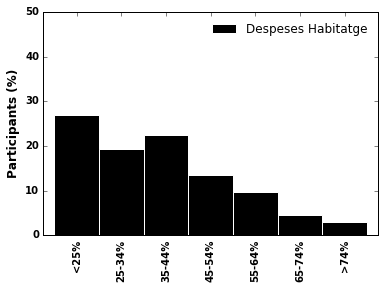

In [50]:
pr5_counts = df_participants_frame['frame_pr5'].value_counts(normalize=True)[['r1', 'r2', 'r3','r4', 'r5', 'r6','r7']]
pr6_counts = df_participants_frame['frame_pr6'].value_counts(normalize=True)[['r1', 'r2', 'r3','r4', 'r5', 'r6','r7']]
index = ['r1', 'r2', 'r3','r4', 'r5', 'r6','r7']
df_expenses = pd.DataFrame({'pr5': pr5_counts, 'pr6': pr6_counts}, index=index)

#plt_expenses = df_expenses.plot(kind='bar', rot=90, width=0.75, color=colors, edgecolor = "black")
plt_expenses = df_expenses['pr5'].plot(kind='bar', rot=90, width=1, color=colors[0], edgecolor = "white")
#plt_expenses = df_expenses['pr6'].plot(kind='bar', rot=90, width=1, color=colors[0], edgecolor = "white")

mapping_pr56 = {'r1': float(0+24)/2, 'r2': float(25+34)/2, 'r3': float(35+44)/2, 'r4': float(45+54)/2, 'r5': float(55+64)/2, 'r6': float(65+74)/2, 'r7': float(75+100)/2, '': None}
df_participants_frame_numeric = df_participants_frame.replace({'frame_pr5': mapping_pr56, 'frame_pr6': mapping_pr56})

#plt.vlines(, 0, 1000, colors=colors[1], linewidth=3)


max_y = 0.5
# plt_expenses.get_legend().remove()
plt_expenses.set_xticklabels(['<25%', '25-34%', '35-44%', '45-54%', '55-64%', '65-74%', '>74%'])
# plt_expenses.set_xticklabels(['A', 'B', 'C','D', 'E', 'F', 'G'])
plt.xticks(**ticks_font)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5], ['0',10,20,30,40,50], **ticks_font)
plt.xlabel('', **axis_font)
plt.ylabel('Participants (%)', **axis_font)
plt.title('', **title_font)
plt.ylim(0,max_y)
plt.legend(['Despeses Habitatge', 'Despeses Habitatge Justes'], fancybox=True, framealpha=0)

#plt.savefig('figures/Granollers/05_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)
plt.savefig('figures/Granollers/05_despeses_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)
#plt.savefig('figures/Granollers/06_despeses_justes_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)

df_participants_frame_numeric['frame_pr5'].describe()
#df_participants_frame_numeric['frame_pr6'].describe()
pr6_counts


#### Participants que són llogueters


En regim de lloguer a qualsevol preu
En regim de lloguer a preu de mercat


r1    0.18750
r2    0.37500
r3    0.34375
r4    0.09375
r5        NaN
r6        NaN
r7        NaN
Name: frame_pr6, dtype: float64

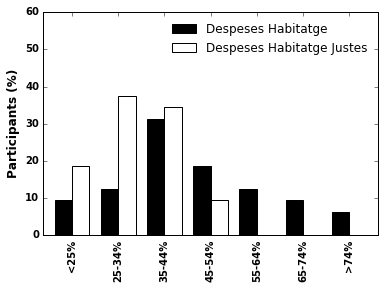

In [51]:
df_participants_socio_frame = pd.concat([df_participants_frame,df_participants_socio], axis=1, join='inner')

print 'En regim de lloguer a qualsevol preu'
df_participants_llogaters = df_participants_socio_frame[(df_participants_socio_frame['socio_pr6']=='r3') | (df_participants_socio_frame['socio_pr6']=='r4')]

print 'En regim de lloguer a preu de mercat'
df_participants_llogaters = df_participants_socio_frame[(df_participants_socio_frame['socio_pr6']=='r3')]

pr5_counts_llogaters = df_participants_llogaters['frame_pr5'].value_counts(normalize=True)[['r1', 'r2', 'r3','r4', 'r5', 'r6','r7']]
pr6_counts_llogaters = df_participants_llogaters['frame_pr6'].value_counts(normalize=True)[['r1', 'r2', 'r3','r4', 'r5', 'r6','r7']]

index = ['r1', 'r2', 'r3','r4', 'r5', 'r6','r7']
df_expenses = pd.DataFrame({'pr5': pr5_counts_llogaters, 'pr6': pr6_counts_llogaters}, index=index)

plt_expenses = df_expenses.plot(kind='bar', rot=90, width=0.75, color=colors, edgecolor = "black")

max_y = 0.60
# plt_expenses.get_legend().remove()
plt_expenses.set_xticklabels(['<25%', '25-34%', '35-44%', '45-54%', '55-64%', '65-74%', '>74%'])
# plt_expenses.set_xticklabels(['A', 'B', 'C','D', 'E', 'F', 'G'])
plt.xticks(**ticks_font)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5, 0.6], ['0',10,20,30,40,50,60], **ticks_font)
plt.xlabel('', **axis_font)
plt.ylabel('Participants (%)', **axis_font)
plt.title('', **title_font)
plt.ylim(0,max_y)
plt.legend(['Despeses Habitatge', 'Despeses Habitatge Justes'], fancybox=True, framealpha=0)

plt.savefig('figures/Granollers/05_llogaters_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)

#pr5_counts_llogaters
pr6_counts_llogaters
#df_participants_llogaters.describe()

### Preguntes finals

In [52]:
text_dataset = 'final_GR' 
df_participants_final = pd.DataFrame(list(df_participants_GR['final']))

#'final_pr5': u[33], # q: Coneixes iniciatives d’habitatge cooperatiu?
#'final_pr6': u[34], # q: En quina mesura creus que les iniciatives d’habitatge cooperatiu poden millorar l’eficiència del model d’habitatge actual? (opcional)
    
    

**pr1:** En quina mesura creus que ha d’haver-hi un control públic de l’habitatge? **pr2:** En quina mesura estàs d’acord amb la necessitat de tenir un sistema que garanteixi la consideració de l’habitatge com un bé de primera necessitat? **pr3:** En quina mesura creus que la presència de pisos buits afecta la situació de l'habitatge al municipi? **pr4:** En quina mesura estàs d’acord amb la necessitat de prioritzar el dret a l’habitatge per a col·lectius vulnerables? 



,final_pr1,final_pr2,final_pr3,final_pr4,final_pr6
count,134.000000,134.000000,134.000000,134.000000,115.000000
mean,6.037313,6.559701,6.059701,6.134328,5.382609
std,1.633331,0.992538,1.675840,1.342151,1.719764
min,0.000000,2.000000,0.000000,0.000000,0.000000
25%,5.250000,7.000000,6.000000,5.000000,5.000000
50%,7.000000,7.000000,7.000000,7.000000,6.000000
75%,7.000000,7.000000,7.000000,7.000000,7.000000
max,7.000000,7.000000,7.000000,7.000000,7.000000


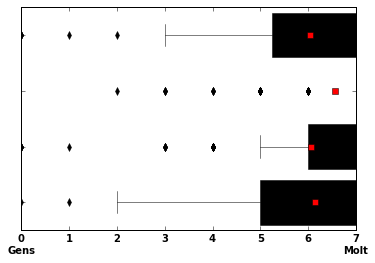

In [53]:
plt.clf()
mapping = {'r1': 0, 'r2': 1, 'r3': 2, 'r4': 3, 'r5': 4, 'r6': 5, 'r7': 6, 'r8': 7, 'rx': None}
df_participants_final_numeric = df_participants_final.replace({'final_pr1': mapping, 'final_pr2': mapping, 'final_pr3': mapping, 'final_pr4': mapping, 'final_pr6': mapping})
ax = sns.boxplot(data=df_participants_final_numeric[['final_pr1','final_pr2','final_pr3','final_pr4']], 
            orient = 'h', linewidth=0.5, showmeans=True, color=colors[0])

ax.set_xticklabels(['0\nGens', '1', '2', '3', '4', '5', '6', '7\nMolt'], **ticks_font)
#ax.set_yticklabels(['Q1', 'Q2', 'Q3', 'Q4'], **ticks_font)
ax.set_yticklabels(['', '', '', ''], **ticks_font)
plt.savefig('figures/Granollers/01_04_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)

#df_participants_final_numeric['final_pr1'].describe()
#df_participants_final_numeric['final_pr2'].describe()
#df_participants_final_numeric['final_pr3'].describe()
#df_participants_final_numeric['final_pr4'].describe()
df_participants_final_numeric.describe()




**pr5** Coneixes iniciatives d’habitatge cooperatiu? **pr6** En quina mesura creus que les iniciatives d’habitatge cooperatiu poden millorar l’eficiència del model d’habitatge actual? (opcional)
    

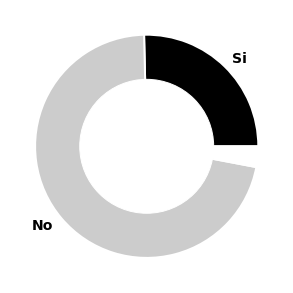

,final_pr6
count,115.000000
mean,5.382609
std,1.719764
min,0.000000
25%,5.000000
50%,6.000000
75%,7.000000
max,7.000000


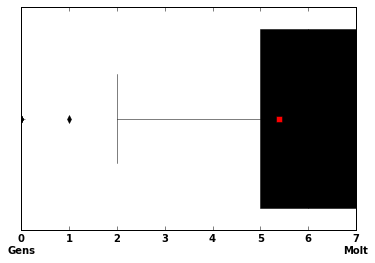

In [54]:
plt.clf()

freq_cooperative = df_participants_final['final_pr5'].value_counts(normalize=True)[['r1', 'r2', 'r3', '']]

labels = ['Si', 'No', '', '']

quatricolors_none = ['black', '#CCCCCC', '#FFFFFF', '#FFFFFF']

fig = plt.figure(figsize=(5,5))
circle = plt.Circle((0,0),0.6,color='white',alpha=1)

patches, texts = plt.pie(freq_cooperative, labels=labels, colors=quatricolors_none,
                         wedgeprops={'linewidth': 2, 'linestyle': 'solid', 'antialiased': True, 'edgecolor': 'white'})

[ _.set_fontsize(14) for _ in texts ]
[ _.set_fontweight('bold') for _ in texts ]


p=plt.gcf()
p.gca().add_artist(circle)
plt.savefig('figures/Granollers/05_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

fig, ax = plt.subplots()

bplot = sns.boxplot(data=df_participants_final_numeric[['final_pr6']], orient = 'h', linewidth=0.5, showmeans=True, color=colors[0])
bplot.set_xticklabels(['0\nGens', '1', '2', '3', '4', '5', '6', '7\nMolt'], **ticks_font)
bplot.set_yticklabels([''], **ticks_font)

for p, artist in enumerate(ax.artists):
    for q in range(p*6, p*6+6):
        line = ax.lines[6]
        line.set_color('white')


plt.savefig('figures/Granollers/06_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)

df_participants_final_numeric[['final_pr6']].describe()
#freq_cooperative                              


In [55]:
print 'Participants que coneixen cooperatives'

cooperativa_si = df_participants_final_numeric[(df_participants_final['final_pr5']=='r1')]
cooperativa_si['final_pr6'].describe()


Participants que coneixen cooperatives


count    34.000000
mean      5.735294
std       1.188552
min       3.000000
25%       5.000000
50%       6.000000
75%       7.000000
max       7.000000
Name: final_pr6, dtype: float64

In [56]:
print 'Participants que no coneixen cooperatives'

cooperativa_no = df_participants_final_numeric[(df_participants_final['final_pr5']=='r2')]
cooperativa_no['final_pr6'].describe()


Participants que no coneixen cooperatives


count    77.000000
mean      5.259740
std       1.887651
min       0.000000
25%       4.000000
50%       6.000000
75%       7.000000
max       7.000000
Name: final_pr6, dtype: float64

### Preu dels lloguer

In [57]:
text_dataset = 'economy_GR' 
df_participants_economy = df_participants_GR[['id', 'intervention', 'house', 'house_price', 'round_rented', 'endowment_final']].copy()
df_participants_economy['decication'] = df_participants_economy['house_price']/rent_GR
#df_participants_economy





#### Preu mitja que els participants han pagat pel lloguer

In [58]:
df_participants_economy[df_participants_economy['house'] == 1]['house_price'].describe()


count    134.000000
mean     585.873359
std       41.085146
min      430.075563
25%      560.000000
50%      588.000000
75%      617.400000
max      714.717675
Name: house_price, dtype: float64

#### Preu mitja que els participants han pagat pel lloguer segons tractament

In [59]:
print 'NONE'
df_participants_economy[(df_participants_economy['house'] == 1) & (df_participants_economy['intervention'] == 'NONE')]['house_price'].describe()


NONE


count     65.000000
mean     585.902052
std       48.343776
min      430.075563
25%      560.000000
50%      588.000000
75%      617.400000
max      714.717675
Name: house_price, dtype: float64

In [60]:
print 'BOTH'
df_participants_economy[(df_participants_economy['house'] == 1) & (df_participants_economy['intervention'] == 'BOTH')]['house_price'].describe()



BOTH


count     69.000000
mean     585.846330
std       33.194335
min      500.364921
25%      560.000000
50%      588.000000
75%      617.400000
max      617.400000
Name: house_price, dtype: float64

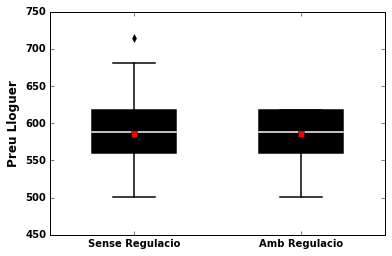

In [61]:
fig, ax = plt.subplots()

# bplot=sns.stripplot(x='intervention', # vertical
#                    y='house_price',
#                    orient = 'v',
#                    data=df_participants_economy, 
#                    jitter=True, 
#                    marker='o', 
#                    palette=bicolors_black, 
#                    edgecolor=bicolors_black, 
#                    facecolors="none")


bplot =sns.boxplot(x='intervention', # vertical
                  y='house_price',
                  orient = 'v', 
                  data=df_participants_economy, 
                  width=.5, 
                  #palette=bicolors_grey, 
                  linewidth=1.5,
                  showmeans=True,
                  color=colors[0])


for p, artist in enumerate(ax.artists):
    for q in range(p*6, p*6+6):
        line = ax.lines[4]
        line.set_color('white')
        line = ax.lines[11]
        line.set_color('white')

    

min_y = 450
max_y = 750
plt.xticks([0,1], ['Sense Regulacio', 'Amb Regulacio'],**ticks_font)
plt.yticks(**ticks_font)
plt.xlabel('', **axis_font)
plt.ylabel('Preu Lloguer', **axis_font)
plt.title('', **title_font)
plt.ylim(min_y, max_y)

plt.savefig('figures/Granollers/01_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)



#### Dedicacio a les despeses de habitatge

Mitjana despeses habitatge


count    134.000000
mean       0.303090
std        0.021255
min        0.222491
25%        0.289705
50%        0.304190
75%        0.319400
max        0.369745
Name: decication, dtype: float64

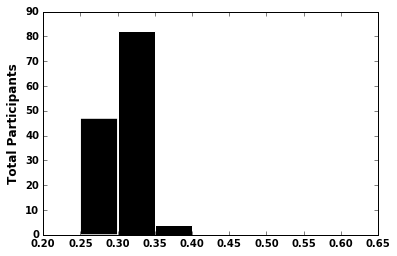

In [62]:
print 'Mitjana despeses habitatge'
df_participants_economy['decication'].describe()

fig, ax = plt.subplots()
df_participants_economy['decication'].hist(bins=[0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65], color=colors[0], edgecolor = "white")
min_y = 0
max_y = 50

plt.xticks(**ticks_font)
plt.yticks(**ticks_font)
plt.xlabel('', **axis_font)
plt.ylabel('Total Participants', **axis_font)
plt.grid(False)

plt.savefig('figures/Granollers/01_dedication_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)

#plt.title('', **title_font)
#plt.ylim(min_y, max_y)

df_participants_economy['decication'].describe()


### Evolució del mercat

#### Mesos que tarden en llogar un habitatge

In [63]:
text_treatment = 'ALL'
df_participants_economy[(df_participants_economy['house'] == 1)]['round_rented'].describe()


count    134.000000
mean       4.291045
std        3.178463
min        1.000000
25%        2.000000
50%        3.000000
75%        6.000000
max       12.000000
Name: round_rented, dtype: float64

In [64]:
text_treatment = 'NONE'
print 'NONE'
df_participants_economy[(df_participants_economy['house'] == 1) & (df_participants_economy['intervention'] == 'NONE')]['round_rented'].describe()


NONE


count    65.000000
mean      4.507692
std       3.491611
min       1.000000
25%       2.000000
50%       3.000000
75%       6.000000
max      12.000000
Name: round_rented, dtype: float64

In [66]:
text_treatment = 'BOTH'
print 'BOTH'
df_participants_economy[(df_participants_economy['house'] == 1) & (df_participants_economy['intervention'] == 'BOTH')]['round_rented'].describe()



BOTH


count    69.000000
mean      4.086957
std       2.863252
min       1.000000
25%       2.000000
50%       4.000000
75%       5.000000
max      12.000000
Name: round_rented, dtype: float64

#### Preus acceptats i no acceptats

In [67]:
num_round = []
selections = []
prices = []
intervention = []
increments = []

for index, d in enumerate(df_participants_GR['rounds']):
    for r in d:
        if r['is_selected'] == 1:
            increments.append(r['increment'])
            num_round.append(r['num_round'])
            selections.append(r['selection'])
            prices.append(r['price'])
            intervention.append(df_participants_GR.iloc[index]['intervention'])
            
df_prices = pd.DataFrame({'num_round': num_round, 'selections': selections, 'prices': prices, 'intervention': intervention, 'increments': increments})


#### Acceptació del preu de entrada



In [68]:
acceptacio = df_prices[df_prices['num_round']==1]['selections'].value_counts(normalize=True)
print 'El %.2f no va aceptar el preu proposat' %(acceptacio[0]*100)
print 'El %.2f va aceptar el preu proposat' %(acceptacio[1]*100)


El 29.55 no va aceptar el preu proposat
El 70.45 va aceptar el preu proposat


#### Preu mitjà que els participants han estat disposats a pagar pel lloguer


In [69]:
print 'Preus acceptats'
df_prices[(df_prices['selections'] == 1)]['prices'].describe()
#df_prices[(df_prices['selections'] == 1)]['prices'].hist()


Preus acceptats


count    274.000000
mean     583.746172
std       33.882065
min      430.075563
25%      560.000000
50%      588.000000
75%      617.400000
max      714.717675
Name: prices, dtype: float64

In [70]:
print 'Preus acceptats tractament sense intervencio'
df_prices[(df_prices['selections'] == 1) & (df_prices['intervention'] == 'NONE')]['prices'].describe()
#df_prices[(df_prices['selections'] == 1)]['prices'].hist()

Preus acceptats tractament sense intervencio


count    132.000000
mean     584.178188
std       38.887288
min      430.075563
25%      560.000000
50%      588.000000
75%      615.856500
max      714.717675
Name: prices, dtype: float64

In [71]:
print 'Preus acceptats tractament amb intervencio'
df_prices[(df_prices['selections'] == 1) & (df_prices['intervention'] == 'BOTH')]['prices'].describe()
#df_prices[(df_prices['selections'] == 1)]['prices'].hist()

Preus acceptats tractament amb intervencio


count    142.000000
mean     583.344579
std       28.590274
min      500.364921
25%      560.000000
50%      588.000000
75%      617.400000
max      617.400000
Name: prices, dtype: float64

In [72]:
print 'Preus no acceptats'
df_prices[(df_prices['selections'] == 0)]['prices'].describe()
#df_prices[(df_prices['selections'] == 0)]['prices'].hist()


Preus no acceptats


count    295.000000
mean     593.407541
std       38.279175
min      452.711119
25%      560.000000
50%      588.000000
75%      617.400000
max      714.717675
Name: prices, dtype: float64

#### Histograma de tots els preus acceptats

,price,1,0,perc_1,perc_0
0,430.0,1.0,0.0,1.000000,0.000000
1,453.0,0.0,1.0,0.000000,1.000000
2,477.0,0.0,1.0,0.000000,1.000000
3,502.0,2.0,1.0,0.666667,0.333333
4,527.0,2.0,3.0,0.400000,0.600000
5,556.0,17.0,11.0,0.607143,0.392857
6,585.0,15.0,16.0,0.483871,0.516129
7,615.0,17.0,24.0,0.414634,0.585366
8,647.0,3.0,8.0,0.272727,0.727273
9,680.0,2.0,4.0,0.333333,0.666667


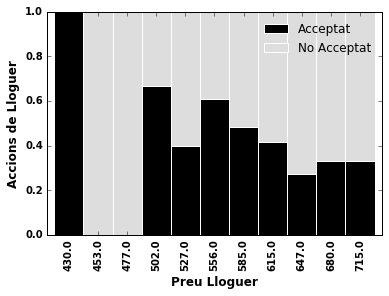

In [73]:
## Binned All Games

df_prices_count = pd.concat([df_prices[(df_prices['selections'] == 1)]['prices'].value_counts(), df_prices[(df_prices['selections'] == 0)]['prices'].value_counts()], axis=1)

df_prices_count.columns = ['1','0']

df_prices_count = df_prices_count.fillna(0)
df_prices_count['perc_1'] = df_prices_count['1'] / (df_prices_count['1'] + df_prices_count['0'])
df_prices_count['perc_0'] = df_prices_count['0'] / (df_prices_count['1'] + df_prices_count['0'])
df_prices_count['price'] = df_prices_count.index


prices_ = [np.round(np.mean(df_prices_count['price'].iloc[0:1])), 
           np.round(np.mean(df_prices_count['price'].iloc[1:2])), 
           np.round(np.mean(df_prices_count['price'].iloc[2:3])), 
           np.round(np.mean(df_prices_count['price'].iloc[3:6])), 
           np.round(np.mean(df_prices_count['price'].iloc[6:11])), 
           np.round(np.mean(df_prices_count['price'].iloc[11:17])), 
           np.round(np.mean(df_prices_count['price'].iloc[17:22])), 
           np.round(np.mean(df_prices_count['price'].iloc[22:26])), 
           np.round(np.mean(df_prices_count['price'].iloc[26:29])), 
           np.round(np.mean(df_prices_count['price'].iloc[29:31])), 
           np.round(np.mean(df_prices_count['price'].iloc[31]))]

ones_ = [np.round(np.mean(df_prices_count['1'].iloc[0:1])), 
           np.round(np.mean(df_prices_count['1'].iloc[1:2])), 
           np.round(np.mean(df_prices_count['1'].iloc[2:3])), 
           np.round(np.mean(df_prices_count['1'].iloc[3:6])), 
           np.round(np.mean(df_prices_count['1'].iloc[6:11])), 
           np.round(np.mean(df_prices_count['1'].iloc[11:17])), 
           np.round(np.mean(df_prices_count['1'].iloc[17:22])), 
           np.round(np.mean(df_prices_count['1'].iloc[22:26])), 
           np.round(np.mean(df_prices_count['1'].iloc[26:29])), 
           np.round(np.mean(df_prices_count['1'].iloc[29:31])), 
           np.round(np.mean(df_prices_count['1'].iloc[31]))]

zeros_ = [np.round(np.mean(df_prices_count['0'].iloc[0:1])), 
           np.round(np.mean(df_prices_count['0'].iloc[1:2])), 
           np.round(np.mean(df_prices_count['0'].iloc[2:3])), 
           np.round(np.mean(df_prices_count['0'].iloc[3:6])), 
           np.round(np.mean(df_prices_count['0'].iloc[6:11])), 
           np.round(np.mean(df_prices_count['0'].iloc[11:17])), 
           np.round(np.mean(df_prices_count['0'].iloc[17:22])), 
           np.round(np.mean(df_prices_count['0'].iloc[22:26])), 
           np.round(np.mean(df_prices_count['0'].iloc[26:29])), 
           np.round(np.mean(df_prices_count['0'].iloc[29:31])), 
           np.round(np.mean(df_prices_count['0'].iloc[31]))]


df_prices_binned=pd.DataFrame()
df_prices_binned['price'] = prices_
df_prices_binned['1'] = ones_
df_prices_binned['0'] = zeros_
df_prices_binned['perc_1'] = df_prices_binned['1'] / (df_prices_binned['1'] + df_prices_binned['0'])
df_prices_binned['perc_0'] = df_prices_binned['0'] / (df_prices_binned['1'] + df_prices_binned['0'])


fig, ax = plt.subplots()
df_prices_binned[['perc_1', 'perc_0']].plot.bar(stacked=True, width=1, position=0.5, edgecolor='white', ax=ax, alpha=1, color=[colors[0], "#dddddd"])
plt.xticks(range(0, len(df_prices_binned['price'])),df_prices_binned['price'], **ticks_font)
plt.yticks(**ticks_font)
plt.xlabel('Preu Lloguer', **axis_font)
plt.ylabel('Accions de Lloguer', **axis_font)
plt.title('', **title_font)
plt.legend(['Acceptat', "No Acceptat"], loc='best', fancybox=True, framealpha=0);

plt.savefig('figures/Granollers/02_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)

df_prices_binned



In [74]:
df_prices_count



,1,0,perc_1,perc_0,price
430.075563,1.0,0.0,1.000000,0.000000,430.075563
452.711119,0.0,1.0,0.000000,1.000000,452.711119
476.538020,0.0,1.0,0.000000,1.000000,476.538020
500.364921,3.0,0.0,1.000000,0.000000,500.364921
501.618968,1.0,2.0,0.333333,0.666667,501.618968
502.876159,2.0,1.0,0.666667,0.333333,502.876159
525.383167,1.0,0.0,1.000000,0.000000,525.383167
525.383167,2.0,0.0,1.000000,0.000000,525.383167
526.699917,2.0,4.0,0.333333,0.666667,526.699917
528.019967,3.0,7.0,0.300000,0.700000,528.019967


#### Histograma dels preus acceptats amb intervencio

Both


,price,1,0,perc_1,perc_0
0,502.0,1.0,1.0,0.500000,0.500000
1,528.0,1.0,2.0,0.333333,0.666667
2,557.0,13.0,7.0,0.650000,0.350000
3,585.0,8.0,8.0,0.500000,0.500000
4,616.0,15.0,19.0,0.441176,0.558824


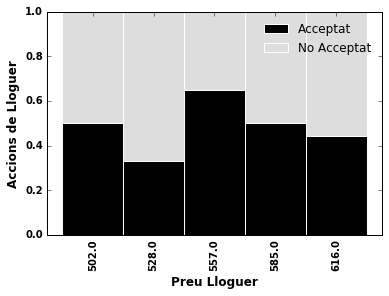

In [75]:
## Binned Both Games

print 'Both'
df_prices_count = pd.concat([df_prices[(df_prices['selections'] == 1) & (df_prices['intervention'] == 'BOTH')]['prices'].value_counts(), df_prices[(df_prices['selections'] == 0) & (df_prices['intervention'] == 'BOTH')]['prices'].value_counts()], axis=1)

df_prices_count.columns = ['1','0']

df_prices_count = df_prices_count.fillna(0)
df_prices_count['perc_1'] = df_prices_count['1'] / (df_prices_count['1'] + df_prices_count['0'])
df_prices_count['perc_0'] = df_prices_count['0'] / (df_prices_count['1'] + df_prices_count['0'])
df_prices_count['price'] = df_prices_count.index


prices_ = [np.round(np.mean(df_prices_count['price'].iloc[0:3])), 
           np.round(np.mean(df_prices_count['price'].iloc[3:6])), 
           np.round(np.mean(df_prices_count['price'].iloc[6:10])), 
           np.round(np.mean(df_prices_count['price'].iloc[10:15])), 
           np.round(np.mean(df_prices_count['price'].iloc[15:18]))]

ones_ = [np.round(np.mean(df_prices_count['1'].iloc[0:3])), 
           np.round(np.mean(df_prices_count['1'].iloc[3:6])), 
           np.round(np.mean(df_prices_count['1'].iloc[6:10])), 
           np.round(np.mean(df_prices_count['1'].iloc[10:15])), 
           np.round(np.mean(df_prices_count['1'].iloc[15:18]))]

zeros_ = [np.round(np.mean(df_prices_count['0'].iloc[0:3])), 
           np.round(np.mean(df_prices_count['0'].iloc[3:6])), 
           np.round(np.mean(df_prices_count['0'].iloc[6:10])), 
           np.round(np.mean(df_prices_count['0'].iloc[10:15])), 
           np.round(np.mean(df_prices_count['0'].iloc[15:18]))]


df_prices_binned=pd.DataFrame()
df_prices_binned['price'] = prices_
df_prices_binned['1'] = ones_
df_prices_binned['0'] = zeros_
df_prices_binned['perc_1'] = df_prices_binned['1'] / (df_prices_binned['1'] + df_prices_binned['0'])
df_prices_binned['perc_0'] = df_prices_binned['0'] / (df_prices_binned['1'] + df_prices_binned['0'])


fig, ax = plt.subplots()
df_prices_binned[['perc_1', 'perc_0']].plot.bar(stacked=True, width=1, position=0.5, edgecolor='white', ax=ax, alpha=1, color=[colors[0], "#dddddd"])
plt.xticks(range(0, len(df_prices_binned['price'])),df_prices_binned['price'], **ticks_font)
plt.yticks(**ticks_font)
plt.xlabel('Preu Lloguer', **axis_font)
plt.ylabel('Accions de Lloguer', **axis_font)
plt.title('', **title_font)
plt.legend(['Acceptat', "No Acceptat"], loc='best', fancybox=True, framealpha=0);

plt.savefig('figures/Granollers/02_both_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)

df_prices_binned



#### Histograma dels preus acceptats sense intervencio

None


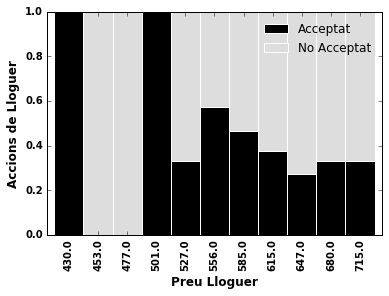

In [76]:
## Binned None Games


print 'None'
df_prices_count = pd.concat([df_prices[(df_prices['selections'] == 1) & (df_prices['intervention'] == 'NONE')]['prices'].value_counts(), df_prices[(df_prices['selections'] == 0) & (df_prices['intervention'] == 'NONE')]['prices'].value_counts()], axis=1)

df_prices_count.columns = ['1','0']

df_prices_count = df_prices_count.fillna(0)
df_prices_count['perc_1'] = df_prices_count['1'] / (df_prices_count['1'] + df_prices_count['0'])
df_prices_count['perc_0'] = df_prices_count['0'] / (df_prices_count['1'] + df_prices_count['0'])
df_prices_count['price'] = df_prices_count.index


prices_ = [np.round(np.mean(df_prices_count['price'].iloc[0:1])), 
           np.round(np.mean(df_prices_count['price'].iloc[1:2])), 
           np.round(np.mean(df_prices_count['price'].iloc[2:3])), 
           np.round(np.mean(df_prices_count['price'].iloc[3:5])), 
           np.round(np.mean(df_prices_count['price'].iloc[5:10])), 
           np.round(np.mean(df_prices_count['price'].iloc[10:16])), 
           np.round(np.mean(df_prices_count['price'].iloc[16:21])), 
           np.round(np.mean(df_prices_count['price'].iloc[21:25])), 
           np.round(np.mean(df_prices_count['price'].iloc[25:28])), 
           np.round(np.mean(df_prices_count['price'].iloc[28:30])), 
           np.round(np.mean(df_prices_count['price'].iloc[30]))]

ones_ = [np.round(np.mean(df_prices_count['1'].iloc[0:1])), 
           np.round(np.mean(df_prices_count['1'].iloc[1:2])), 
           np.round(np.mean(df_prices_count['1'].iloc[2:3])), 
           np.round(np.mean(df_prices_count['1'].iloc[3:5])), 
           np.round(np.mean(df_prices_count['1'].iloc[5:10])), 
           np.round(np.mean(df_prices_count['1'].iloc[10:16])), 
           np.round(np.mean(df_prices_count['1'].iloc[16:21])), 
           np.round(np.mean(df_prices_count['1'].iloc[21:25])), 
           np.round(np.mean(df_prices_count['1'].iloc[25:28])), 
           np.round(np.mean(df_prices_count['1'].iloc[28:30])), 
           np.round(np.mean(df_prices_count['1'].iloc[30]))]

zeros_ = [np.round(np.mean(df_prices_count['0'].iloc[0:1])), 
           np.round(np.mean(df_prices_count['0'].iloc[1:2])), 
           np.round(np.mean(df_prices_count['0'].iloc[2:3])), 
           np.round(np.mean(df_prices_count['0'].iloc[3:5])), 
           np.round(np.mean(df_prices_count['0'].iloc[5:10])), 
           np.round(np.mean(df_prices_count['0'].iloc[10:16])), 
           np.round(np.mean(df_prices_count['0'].iloc[16:21])), 
           np.round(np.mean(df_prices_count['0'].iloc[21:25])), 
           np.round(np.mean(df_prices_count['0'].iloc[25:28])), 
           np.round(np.mean(df_prices_count['0'].iloc[28:30])), 
           np.round(np.mean(df_prices_count['0'].iloc[30]))]


df_prices_binned=pd.DataFrame()
df_prices_binned['price'] = prices_
df_prices_binned['1'] = ones_
df_prices_binned['0'] = zeros_
df_prices_binned['perc_1'] = df_prices_binned['1'] / (df_prices_binned['1'] + df_prices_binned['0'])
df_prices_binned['perc_0'] = df_prices_binned['0'] / (df_prices_binned['1'] + df_prices_binned['0'])


fig, ax = plt.subplots()
df_prices_binned[['perc_1', 'perc_0']].plot.bar(stacked=True, width=1, position=0.5, edgecolor='white', ax=ax, alpha=1, color=[colors[0], "#dddddd"])
plt.xticks(range(0, len(df_prices_binned['price'])),df_prices_binned['price'], **ticks_font)
plt.yticks(**ticks_font)
plt.xlabel('Preu Lloguer', **axis_font)
plt.ylabel('Accions de Lloguer', **axis_font)
plt.title('', **title_font)
plt.legend(['Acceptat', "No Acceptat"], loc='best', fancybox=True, framealpha=0);

plt.savefig('figures/Granollers/02_none_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)


In [77]:
df_prices_count


,1,0,perc_1,perc_0,price
430.075563,1.0,0.0,1.000000,0.000000,430.075563
452.711119,0.0,1.0,0.000000,1.000000,452.711119
476.538020,0.0,1.0,0.000000,1.000000,476.538020
500.364921,2.0,0.0,1.000000,0.000000,500.364921
501.618968,0.0,1.0,0.000000,1.000000,501.618968
525.383167,1.0,0.0,1.000000,0.000000,525.383167
525.383167,2.0,0.0,1.000000,0.000000,525.383167
526.699917,2.0,3.0,0.400000,0.600000,526.699917
528.019967,1.0,4.0,0.200000,0.800000,528.019967
529.343325,1.0,3.0,0.250000,0.750000,529.343325


### Evolucio del preu del lloger

,0,1,2,3,4,5,6,7,8,9,10,11
0,560.0,588.0,617.4,586.53,615.8565,615.856500,585.063675,614.316859,583.601016,554.420965,526.699917,500.364921
1,560.0,588.0,617.4,617.40,617.4000,617.400000,586.530000,557.203500,NaN,NaN,NaN,NaN
2,560.0,588.0,617.4,617.40,617.4000,617.400000,NaN,NaN,NaN,NaN,NaN,NaN
3,560.0,588.0,617.4,617.40,617.4000,617.400000,586.530000,NaN,NaN,NaN,NaN,NaN
4,560.0,588.0,617.4,617.40,617.4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,560.0,588.0,617.4,617.40,617.4000,617.400000,586.530000,557.203500,529.343325,502.876159,NaN,NaN
6,560.0,588.0,617.4,617.40,617.4000,586.530000,615.856500,585.063675,555.810491,528.019967,NaN,NaN
7,560.0,588.0,617.4,617.40,617.4000,586.530000,557.203500,529.343325,502.876159,528.019967,501.618968,501.618968
8,560.0,588.0,617.4,617.40,617.4000,586.530000,NaN,NaN,NaN,NaN,NaN,NaN
9,560.0,588.0,617.4,617.40,617.4000,617.400000,NaN,NaN,NaN,NaN,NaN,NaN


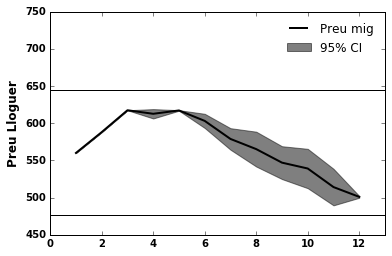

In [78]:
df_games = pd.DataFrame(games)
df_games_treatment = df_games[(df_games['control_intervention'] == 'BOTH') & (df_games['status'] != 'TEST')]

prices_rounds = []

for i, row in df_games_treatment.iterrows():
    rounds = [r['num_round'] for r in df_games_treatment['rounds'][i]]
    price = [r['price_init'] for r in df_games_treatment['rounds'][i]]
    prices_rounds.append(np.array(price))

    
df_prices_rounds = pd.DataFrame(data=prices_rounds)
df_prices_rounds

price_average = df_prices_rounds.loc[:,:].mean()
price_std = df_prices_rounds.loc[:,:].std()
price_sem = df_prices_rounds.loc[:,:].sem()

#ax = sns.lineplot(x=range(0, len(price_average)), y=price_average)

plt.figure()
error_lower = [price_average[i] -  1.96*(price_sem[i]) for i, e in enumerate(price_average)]
error_higher = [price_average[i] +  1.96*(price_sem[i]) for i, e in enumerate(price_average)]

#for g in games:
#    plt.plot(range(1,13,1), g['round_contributions'], color=color.BLUE, linewidth=.1)

plt.fill_between(range(1,len(price_average)+1,1), error_lower, error_higher, color="000000", alpha=0.5, zorder=3, label='95% CI')
plt.plot(range(1,len(price_average)+1,1), price_average, color="black", zorder=4, label='Preu mig', linewidth=2)

plt.ylim(450,750)
plt.hlines(high_limit_GR, 0, 13, colors='black', linewidth=1, linestyles='solid', label='')
plt.hlines(low_limit_GR, 0, 13, colors='black', linewidth=1, linestyles='solid', label='')
plt.xlim(0,13)
plt.xticks(**ticks_font)
plt.yticks(**ticks_font)
plt.xlabel('', **axis_font)
plt.ylabel('Preu Lloguer', **axis_font)
plt.title('', **title_font)
plt.legend(fancybox=True, framealpha=0)
ax = plt.axes()

plt.savefig('figures/Granollers/03_treatment_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)

df_prices_rounds


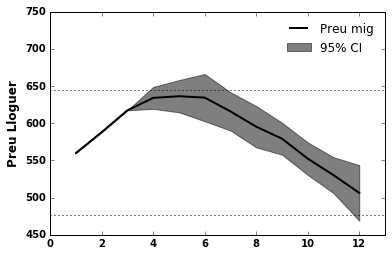

In [79]:
df_games = pd.DataFrame(games)
df_games_no_treatment = df_games[(df_games['control_intervention'] == 'NONE') & (df_games['status'] != 'TEST')]

prices_rounds = []

for i, row in df_games_no_treatment.iterrows():
    rounds = [r['num_round'] for r in df_games_no_treatment['rounds'][i]]
    price = [r['price_init'] for r in df_games_no_treatment['rounds'][i]]
    prices_rounds.append(np.array(price))

    
df_prices_rounds = pd.DataFrame(data=prices_rounds)
df_prices_rounds

price_average = df_prices_rounds.loc[:,:].mean()
price_std = df_prices_rounds.loc[:,:].std()
price_sem = df_prices_rounds.loc[:,:].sem()

#ax = sns.lineplot(x=range(0, len(price_average)), y=price_average)

plt.figure()
error_lower = [price_average[i] -  1.96*(price_sem[i]) for i, e in enumerate(price_average)]
error_higher = [price_average[i] +  1.96*(price_sem[i]) for i, e in enumerate(price_average)]

#for g in games:
#    plt.plot(range(1,13,1), g['round_contributions'], color=color.BLUE, linewidth=.1)

plt.fill_between(range(1,len(price_average)+1,1), error_lower, error_higher, color="000000", alpha=0.5, zorder=3, label='95% CI')
plt.plot(range(1,len(price_average)+1,1), price_average, color="black", zorder=4, label='Preu mig', linewidth=2)

plt.ylim(450,750)
plt.hlines(high_limit_GR, 0, 13, colors='black', linewidth=1, linestyles='dotted', label='')
plt.hlines(low_limit_GR, 0, 13, colors='black', linewidth=1, linestyles='dotted', label='')
plt.xlim(0,13)
plt.xticks(**ticks_font)
plt.yticks(**ticks_font)
plt.xlabel('', **axis_font)
plt.ylabel('Preu Lloguer', **axis_font)
plt.title('', **title_font)
plt.legend(fancybox=True, framealpha=0)
ax = plt.axes()

plt.savefig('figures/Granollers/03_no_treatment_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)


### Estalvis en funcio del mes que es lloga

[1135.95331954  970.44085148 1310.66792017  866.00597553  904.37054343
 1226.77861892 1291.49534807 1331.38349386 1304.97631702 1327.06774887
  709.39706841 1357.89769364]
12


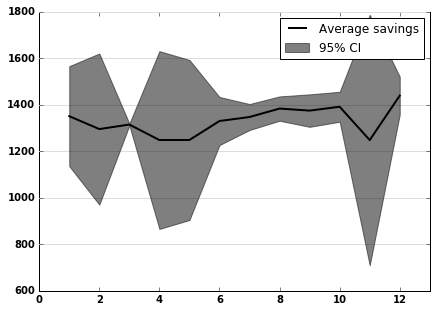

In [80]:
df_round_savings = df_participants_economy[df_participants_economy['house'] == 1][['round_rented','endowment_final']]

#df_round_savings.groupby('round_rented').count()

savings_average = df_round_savings.groupby('round_rented').mean()
savings_std = df_round_savings.groupby('round_rented').std()
savings_sem = df_round_savings.groupby('round_rented').sem()



savings = pd.concat([df_round_savings.groupby('round_rented').count(),
                     savings_average.fillna(0), 
                     savings_sem.fillna(0), 
                     savings_std.fillna(0)], 
                     axis=1, join='inner')
savings.columns = ['n', 'mean', 'std', 'sem']

savings['error_higher'] = savings['mean'] + 1.96*savings['sem']
savings['error_lower'] = savings['mean'] - 1.96*savings['sem']

rounds = savings.index.values
average = savings.iloc[:,1].values
error_lower = savings.iloc[:,5].values
error_higher = savings.iloc[:,4].values

print error_lower
print len(error_lower)

#ax = sns.lineplot(x=range(0, len(price_average)), y=price_average)

fig = plt.figure(figsize=(7,5))

#error_lower = 
#error_higher = 

#for g in games:
#    plt.plot(range(1,13,1), g['round_contributions'], color=color.BLUE, linewidth=.1)

plt.fill_between(rounds, error_lower, error_higher, color="000000", alpha=0.5, zorder=3, label='95% CI')
plt.plot(rounds, average, color="black", zorder=4, label='Average savings', linewidth=2)

plt.ylim()
plt.xlim(0,13)
plt.xticks(**ticks_font)
plt.yticks(**ticks_font)
plt.xlabel('', **axis_font)
plt.ylabel('', **axis_font)
plt.title('', **title_font)
plt.legend()
ax = plt.axes()
ax.yaxis.grid(color='#DDDDDD', linestyle='-', linewidth=1)

plt.savefig('figures/Granollers/04_'+text_dataset+'.png', bbox_inches='tight', dpi=300)


In [81]:
savings

,n,mean,std,sem,error_higher,error_lower
round_rented,,,,,,
1,26,1351.095000,21.526916,109.766164,1566.236680,1135.953320
2,24,1295.602917,33.863994,165.899013,1620.764982,970.440851
3,18,1315.070556,0.529444,2.246243,1319.473191,1310.667920
4,19,1248.484211,44.768635,195.141957,1630.962446,866.005976
5,12,1248.715000,50.716164,175.685947,1593.059457,904.370543
6,8,1330.243956,18.663531,52.788437,1433.709294,1226.778619
7,3,1347.471989,16.488841,28.559511,1403.448629,1291.495348
8,4,1383.788888,13.368723,26.737446,1436.194282,1331.383494
9,5,1375.032071,15.984635,35.742731,1445.087824,1304.976317


#### Socio + Polítiques Públiques

In [82]:
df_socio_frame = pd.concat([df_participants_socio, df_participants_frame], axis=1, join='inner')
df_socio_frame.tail()

,socio_pr1,socio_pr2,socio_pr3,socio_pr4,socio_pr5,socio_pr6,socio_pr7,frame_pr1,frame_pr2,frame_pr3,frame_pr4,frame_pr5,frame_pr6
129,,,,,,,,,,,,,
130,W,r7,08401,r5,r2,r1,r2,r3,r3,r3,r5,r1,r2
131,W,r5,08400,r2,r3,r3,r2,r2,r2,r3,r4,r1,r4
132,W,r4,08530,r5,r2,r1,r2,r2,r3,r3,r4,r2,r2
133,M,r4,08530,r5,r3,r1,r2,r2,r3,r3,r1,r2,r2


|  |socio_pr1|
|----------|
|r1| Home | 
|r2| Dona | 
|r3| No binària | 
|r4| No vull contestar |

**pr2:** En quina mesura estàs d'acord amb una regulació que limiti el preu del lloguer? **pr3:** En quina mesura estàs d'acord amb una regulació fiscal que permeti la concessió d'ajuts per facilitar l'accés a l'habitatge i mantenir el preu?

||frame_pr2|frame_pr3|
|---------------------|
|r1|Poc|Poc|
|r2|Normal|Normal|
|r3|Molt|Molt|




Correlacio entre genere i la limitacio de renta


socio_pr1,M,W
frame_pr2,,
r1,0.030303,0.037879
r2,0.075758,0.128788
r3,0.219697,0.507576


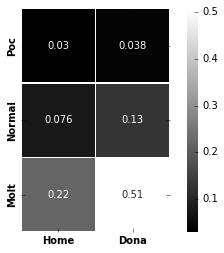

In [83]:
print 'Correlacio entre genere i la limitacio de renta'

df_gender_limit = df_socio_frame[((df_socio_frame['socio_pr1'] == 'M') | (df_socio_frame['socio_pr1'] == 'W')) 
                                 & (df_socio_frame['socio_pr1']!='') & (df_socio_frame['frame_pr2']!='')]

cross = pd.crosstab(df_gender_limit.frame_pr2, df_gender_limit.socio_pr1, normalize=True)

xticks_labels = ['Home', 'Dona']
yticks_labels = ['Poc', 'Normal', 'Molt']

plt.clf()
ax = sns.heatmap(cross, cmap='gray',square=True, linewidths=.5, xticklabels=xticks_labels, yticklabels=yticks_labels, annot=True)

ax.set_ylabel('')    
ax.set_xlabel('')
plt.xticks(**ticks_font)
plt.yticks(**ticks_font)

cross


|| socio_pr5 |
|------------|
|r1|Sol|
|r2|Llar sense persones a càrrec|
|r3|Llar amb persones a càrrec|
|r4|Més persones que no són parella|

**pr2:** En quina mesura estàs d'acord amb una regulació que limiti el preu del lloguer? **pr3:** En quina mesura estàs d'acord amb una regulació fiscal que permeti la concessió d'ajuts per facilitar l'accés a l'habitatge i mantenir el preu?

||frame_pr2|frame_pr3|
|---------------------|
|r1|Poc|Poc|
|r2|Normal|Normal|
|r3|Molt|Molt|

Correlacio entre tipologia de llar i la limitacio de renta


socio_pr5,r1,r2,r3,r4
frame_pr2,,,,
r1,0.007519,0.007519,0.030075,0.022556
r2,0.022556,0.030075,0.112782,0.037594
r3,0.067669,0.195489,0.375940,0.090226


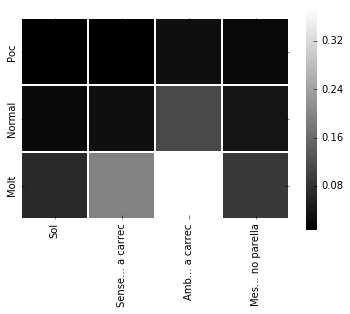

In [84]:
print 'Correlacio entre tipologia de llar i la limitacio de renta'

df_llar_limit = df_socio_frame[(df_socio_frame['socio_pr5']!='') & (df_socio_frame['frame_pr2']!='')]

cross = pd.crosstab(df_llar_limit.frame_pr2,df_llar_limit.socio_pr5, normalize=True)

xticks_labels = ['Sol', 'Sense... a carrec', 'Amb... a carrec', 'Mes... no parella']
yticks_labels = ['Poc', 'Normal', 'Molt']
ax = sns.heatmap(cross, cmap='gray',square=True, linewidths=.5, xticklabels=xticks_labels, yticklabels=yticks_labels)

ax.set_ylabel('')    
ax.set_xlabel('')

cross



#### Règim de tinença de la teva llar
| |socio_pr6|
|----------|
|r1|En propietat|
|r2|En propietat pendent de pagament (hipoteca)|
|r3|En lloguer o relloguer a preu de mercat|
|r4|En lloguer o relloguer a preu inferior al de mercat|
|r5|En cessió gratuïta|
|r6|Habitació de lloguer|
|r7|Ocupació|
|r8|Altres|

**pr2:** En quina mesura estàs d'acord amb una regulació que limiti el preu del lloguer? **pr3:** En quina mesura estàs d'acord amb una regulació fiscal que permeti la concessió d'ajuts per facilitar l'accés a l'habitatge i mantenir el preu?

||frame_pr2|frame_pr3|
|---------------------|
|r1|Poc|Poc|
|r2|Normal|Normal|
|r3|Molt|Molt|

Correlacio entre regim de tinença i la limitacio de renta


socio_pr6,r1,r2,r3,r4,r6,r7,r8
frame_pr2,,,,,,,
r1,0.015038,0.030075,0.000000,0.007519,0.015038,0.000000,0.000000
r2,0.112782,0.037594,0.015038,0.007519,0.015038,0.000000,0.015038
r3,0.218045,0.142857,0.225564,0.052632,0.045113,0.007519,0.037594


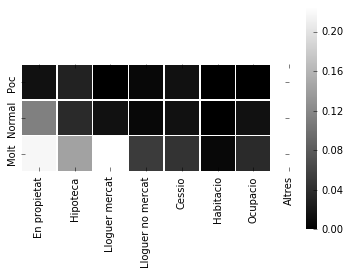

In [85]:
print 'Correlacio entre regim de tinença i la limitacio de renta'

df_regim_limit = df_socio_frame[(df_socio_frame['socio_pr6']!='') & (df_socio_frame['frame_pr2']!='')]

cross = pd.crosstab(df_regim_limit.frame_pr2,df_regim_limit.socio_pr6, normalize=True)

xticks_labels = ['En propietat', 'Hipoteca', 'Lloguer mercat', 'Lloguer no mercat', 'Cessio', 'Habitacio', 'Ocupacio', 'Altres']
yticks_labels = ['Poc', 'Normal', 'Molt']
ax = sns.heatmap(cross, cmap='gray',square=True, linewidths=.5, xticklabels=xticks_labels, yticklabels=yticks_labels)

ax.set_ylabel('')    
ax.set_xlabel('')

cross



### Frecuencia de preus acceptats en funcio de les ronda a la que acaba el dilema

In [86]:
df_games_GR['final_round'] = np.nan
df_games_GR['final_round_rent'] = np.nan
df_games_GR['final_price_rent'] = np.nan
df_games_GR['total_houses_rented'] = np.nan
df_games_GR['comment'] = ''
df_games_GR['limits'] = np.nan

for i, row in df_games_GR.iterrows():
    df_games_GR['final_round'].iloc[i] = len(row['rounds'])
    rent_actions = []
    rent_price = []
    market_price = []
    non_increment = []
    for r in row['rounds']:
        market_price.append(r['price_init'])
        if r['is_rented'] == 1:
            rent_actions.append(r['num_round'])
            rent_price.append(np.round(r['price_init'],2))
            if r['increment'] == 0:
                non_increment.append(r['num_round'])

    df_games_GR['final_price_rent'].iloc[i] = rent_price[len(rent_price)-1]
    df_games_GR['total_houses_rented'].iloc[i] = len(rent_actions)
    df_games_GR['final_round_rent'].iloc[i] = rent_actions[len(rent_actions)-1]
    
    if df_games_GR['control_intervention'].iloc[i] == 'BOTH':
        df_games_GR['limits'].iloc[i] = len(non_increment)

    if len(rent_actions) < 6 and len(row['rounds']) < 12:
        df_games_GR['comment'].iloc[i] = 'INCIDENT'
    
df_games_GR

/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,control_intervention,experiment,id,rounds,status,final_round,final_round_rent,final_price_rent,total_houses_rented,comment,limits
0,NONE,Granollers,5,"[{u'is_rented': 1, u'user_id': 25, u'price_fin...",FINISHED,9.0,9.0,612.78,6.0,,NaN
1,BOTH,Granollers,6,"[{u'is_rented': 1, u'user_id': 32, u'price_fin...",FINISHED,12.0,12.0,500.36,6.0,,1.0
2,NONE,Granollers,7,"[{u'is_rented': 1, u'user_id': 42, u'price_fin...",FINISHED,11.0,11.0,553.03,6.0,,NaN
3,BOTH,Granollers,8,"[{u'is_rented': 1, u'user_id': 48, u'price_fin...",FINISHED,8.0,8.0,557.20,6.0,,3.0
4,NONE,Granollers,9,"[{u'is_rented': 1, u'user_id': 54, u'price_fin...",FINISHED,12.0,12.0,525.38,6.0,,NaN
5,BOTH,Granollers,10,"[{u'is_rented': 1, u'user_id': 56, u'price_fin...",FINISHED,6.0,6.0,617.40,6.0,,4.0
6,NONE,Granollers,11,"[{u'is_rented': 1, u'user_id': 63, u'price_fin...",FINISHED,10.0,10.0,582.14,6.0,,NaN
7,BOTH,Granollers,12,"[{u'is_rented': 1, u'user_id': 69, u'price_fin...",FINISHED,7.0,7.0,586.53,6.0,,3.0
8,NONE,Granollers,13,"[{u'is_rented': 1, u'user_id': 76, u'price_fin...",FINISHED,12.0,12.0,430.08,4.0,,NaN
9,BOTH,Granollers,14,"[{u'is_rented': 1, u'user_id': 83, u'price_fin...",FINISHED,5.0,5.0,617.40,5.0,INCIDENT,3.0


final_round_rent,6.0,7.0,8.0,9.0,10.0,12.0
total_houses_rented,,,,,,
6.0,2,1,1,1,3,2


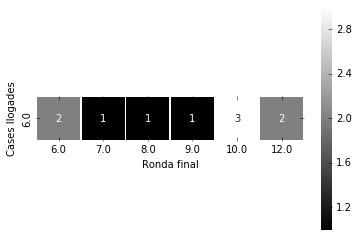

In [87]:
df_games_both = df_games_GR[(df_games_GR['control_intervention']=='BOTH') & (df_games_GR['comment']!='INCIDENT')]

cross = pd.crosstab(df_games_both.total_houses_rented,df_games_both.final_round_rent)

xticks_labels = []
yticks_labels = []
ax = sns.heatmap(cross, cmap='gray',square=True, linewidths=.5, annot=True)

ax.set_xlabel('Ronda final')    
ax.set_ylabel('Cases llogades')

cross

In [88]:
df_games_both.groupby(['final_round_rent','total_houses_rented', 'limits', 'final_price_rent']).size()


final_round_rent  total_houses_rented  limits  final_price_rent
6.0               6.0                  4.0     617.40              2
7.0               6.0                  3.0     586.53              1
8.0               6.0                  3.0     557.20              1
9.0               6.0                  2.0     555.81              1
10.0              6.0                  0.0     582.14              1
                                       2.0     528.02              1
                                       3.0     502.88              1
12.0              6.0                  1.0     500.36              1
                                       2.0     501.62              1
dtype: int64

final_round_rent,6.0,9.0,10.0,11.0,12.0
total_houses_rented,,,,,
4.0,0,0,0,0,1
6.0,1,1,2,3,4


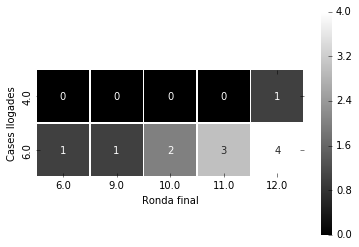

In [89]:
df_games_none = df_games_GR[(df_games_GR['control_intervention']=='NONE') & (df_games_GR['comment']!='INCIDENT')]

cross = pd.crosstab(df_games_none.total_houses_rented, df_games_none.final_round_rent)

xticks_labels = []
yticks_labels = []
ax = sns.heatmap(cross, cmap='gray',square=True, linewidths=.5, annot=True)

ax.set_xlabel('Ronda final')    
ax.set_ylabel('Cases llogades')

cross


In [90]:
df_games_none.groupby(['final_round_rent','total_houses_rented', 'final_price_rent']).size()


final_round_rent  total_houses_rented  final_price_rent
6.0               6.0                  714.72              1
9.0               6.0                  612.78              1
10.0              6.0                  582.14              2
11.0              6.0                  553.03              3
12.0              4.0                  430.08              1
                  6.0                  525.38              4
dtype: int64

### Preus de lloguer segons la pressió del mercat

#### Consideram que les 6 primeres rondes són les que tenen més pressió

In [91]:
print 'Average price houses rented in the first 6 rounds: %.2f' %(df_participants_economy[(df_participants_economy['round_rented']<7)]['house_price'].mean())
print 'Without regulation'
print 'Average price houses rented in the first 6 rounds: %.2f' %(df_participants_economy[(df_participants_economy['round_rented']<7) & (df_participants_economy['intervention']=='NONE')]['house_price'].mean())
print 'With regulation'
print 'Average price houses rented in the first 6 rounds: %.2f' %(df_participants_economy[(df_participants_economy['round_rented']<7) & (df_participants_economy['intervention']=='BOTH')]['house_price'].mean())



Average price houses rented in the first 6 rounds: 597.78
Without regulation
Average price houses rented in the first 6 rounds: 599.90
With regulation
Average price houses rented in the first 6 rounds: 595.93


#### Consideram que les 6 darreres rondes són les que tenen menys pressió


In [92]:
print 'Average price houses rented in the first 6 rounds: %.2f' %(df_participants_economy[(df_participants_economy['round_rented']>6)]['house_price'].mean())
print 'Without regulation'
print 'Average price houses rented in the first 6 rounds: %.2f' %(df_participants_economy[(df_participants_economy['round_rented']>6) & (df_participants_economy['intervention']=='NONE')]['house_price'].mean())
print 'With regulation'
print 'Average price houses rented in the first 6 rounds: %.2f' %(df_participants_economy[(df_participants_economy['round_rented']>6) & (df_participants_economy['intervention']=='BOTH')]['house_price'].mean())


Average price houses rented in the first 6 rounds: 538.68
Without regulation
Average price houses rented in the first 6 rounds: 539.24
With regulation
Average price houses rented in the first 6 rounds: 537.97


#### Calculam un index de pressió que sigui funció del número de participants que no tenen casa i les rondes que queden per llogar una casa

#### Impacte de les polítiques de habitatge

In [93]:
df_games = pd.DataFrame(games)

df_games_valid = df_games[(df_games['status'] != 'TEST')]
df_games_valid

df_games_no_treatment = df_games[(df_games['control_intervention'] == 'NONE') & (df_games['status'] != 'TEST')]
df_games_no_treatment

df_games = pd.DataFrame(games)
df_games_treatment = df_games[(df_games['control_intervention'] == 'BOTH') & (df_games['status'] != 'TEST')]
df_games_treatment


increments_valid = []
increments_no_treatment = []
increments_treatment = []

price_valid = []
price_no_treatment = []
price_treatment = []

for round_ in df_games_valid['rounds']:
    for r in round_:
        increments_valid.append(r['increment'])
        price_valid.append(r['price_init'])
        
df_games_valid_limits = pd.DataFrame()
df_games_valid_limits['increment'] = increments_valid
df_games_valid_limits['price'] = price_valid
df_games_valid_limits['increment'].value_counts(normalize=True)

for round_ in df_games_no_treatment['rounds']:
    for r in round_:
        increments_no_treatment.append(r['increment'])
        price_no_treatment.append(r['price_init'])
        
df_games_no_treatment_limits = pd.DataFrame()
df_games_no_treatment_limits['increment'] = increments_no_treatment
df_games_no_treatment_limits['price'] = price_no_treatment
df_games_no_treatment_limits['increment'].value_counts(normalize=True)

for round_ in df_games_treatment['rounds']:
    for r in round_:
        increments_treatment.append(r['increment'])
        price_treatment.append(r['price_init'])
        
df_games_treatment_limits = pd.DataFrame()
df_games_treatment_limits['increment'] = increments_treatment
df_games_treatment_limits['price'] = price_treatment

df_games_treatment_limits['increment'].value_counts(normalize=True)
#df_games_no_treatment_limits['increment'].value_counts(normalize=True)


## No limits
above_no_limit = len(df_games_no_treatment_limits[(df_games_no_treatment_limits['price']>high_limit_GR)])/float(len(df_games_no_treatment_limits))
under_no_limit = len(df_games_no_treatment_limits[(df_games_no_treatment_limits['price']<low_limit_GR)])/float(len(df_games_no_treatment_limits))
between_no_limit = len(df_games_no_treatment_limits[(df_games_no_treatment_limits['price']>low_limit_GR) & (df_games_no_treatment_limits['price']<high_limit_GR)])/float(len(df_games_no_treatment_limits))

counts_no_treatment_limits = [under_no_limit, between_no_limit, above_no_limit]

above_limit = len(df_games_treatment_limits[(df_games_treatment_limits['price']*1.05>high_limit_GR)])/float(len(df_games_treatment_limits))
under_limit = len(df_games_treatment_limits[(df_games_treatment_limits['price']*0.95<low_limit_GR)])/float(len(df_games_treatment_limits))
between_limit = len(df_games_treatment_limits[(df_games_treatment_limits['price']*0.95>low_limit_GR) & (df_games_treatment_limits['price']*1.05<high_limit_GR)])/float(len(df_games_treatment_limits))

counts_treatment_limits = [under_limit, between_limits, above_limit]

df_counts_limits = pd.DataFrame()
df_counts_limits['no_treatment'] = counts_no_treatment_limits
df_counts_limits['treatment'] = counts_treatment_limits

#index = ['r1', 'r2', 'r3','r4', 'r5', 'r6','r7']
#df_expenses = pd.DataFrame({'pr5': pr5_counts_llogaters, 'pr6': pr6_counts_llogaters}, index=index)

plt_limits = df_counts_limits.plot(kind='bar', rot=0, width=0.75, color=colors, edgecolor = "black")

#max_y = 0.60
# plt_expenses.get_legend().remove()
plt_limits.set_xticklabels(['< limit inferior', '', '> limit superior'])
# plt_expenses.set_xticklabels(['A', 'B', 'C','D', 'E', 'F', 'G'])
#plt.xticks(**ticks_font)
#plt.yticks([0,0.1,0.2,0.3,0.4,0.5, 0.6], ['0',10,20,30,40,50,60], **ticks_font)
#plt.xlabel('', **axis_font)
#plt.ylabel('Participants (%)', **axis_font)
#plt.title('', **title_font)
#plt.ylim(0,max_y)
#plt.legend(['Despeses Habitatge', 'Despeses Habitatge Justes'], fancybox=True, framealpha=0)

#plt.savefig('figures/05_llogaters_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)
df_counts_limits


# primera vegada que es toca el limit
# dispersio a un pas (probabilitat de pujar)

NameError: name 'between_limits' is not defined